In [11]:
#Goupt 8
#Google Store

%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns 
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

Sneak peek at the dataset

In [12]:
df = pd.read_csv('../Data Preprocessing/myGooglePlay.csv')
#df = df.drop(columns = 'Index')
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']

In [13]:
print('Number of apps in the dataset : ' , len(df))

Number of apps in the dataset :  3356


Data Cleaning:
1.Remove '+' from 'Number of Installs' to make it numeric

In [14]:
# - Installs : Remove + and ,
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))
#print(type(df['Installs'].values))
df['Size_M'] = df['Size_M'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))
#df.sample(7)

Basic EDA:
This is the basic exploratory analysis to look for any evident patterns or relationships between the features. 

Which category has the highest share of (active) apps in the market?

In [15]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

* Utilities and Game apps have the highest market prevelance.

* Social Networking, Photo & Viedo, Lifestyle and Business apps are also catching up.

Average rating of apps
--Do any apps perform really good or really bad?

In [16]:
import plotly.graph_objs as go
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5},
        marker = dict(
            color = 'rgb(229, 122, 25)',
            opacity=0.85),
)]
layout = go.Layout(
    title = 'Average rating of apps --Do any apps perform really good or really bad?',
)
fig = go.Figure(data=data, layout=layout)
print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.281108462455304


App ratings across categories - One Way Anova Test

Best performing categories

In [17]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)



data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data})

Average rating =  4.278662420382165


Sizing Strategy - Light Vs Bulky?
How do app sizes impact the app rating?

In [18]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size_M > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

#for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size_M'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(list(set(groups_temp.Category)))]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout},filename="category.html")


Most bulky apps ( >50MB) belong to the Games and Business category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

Correlations

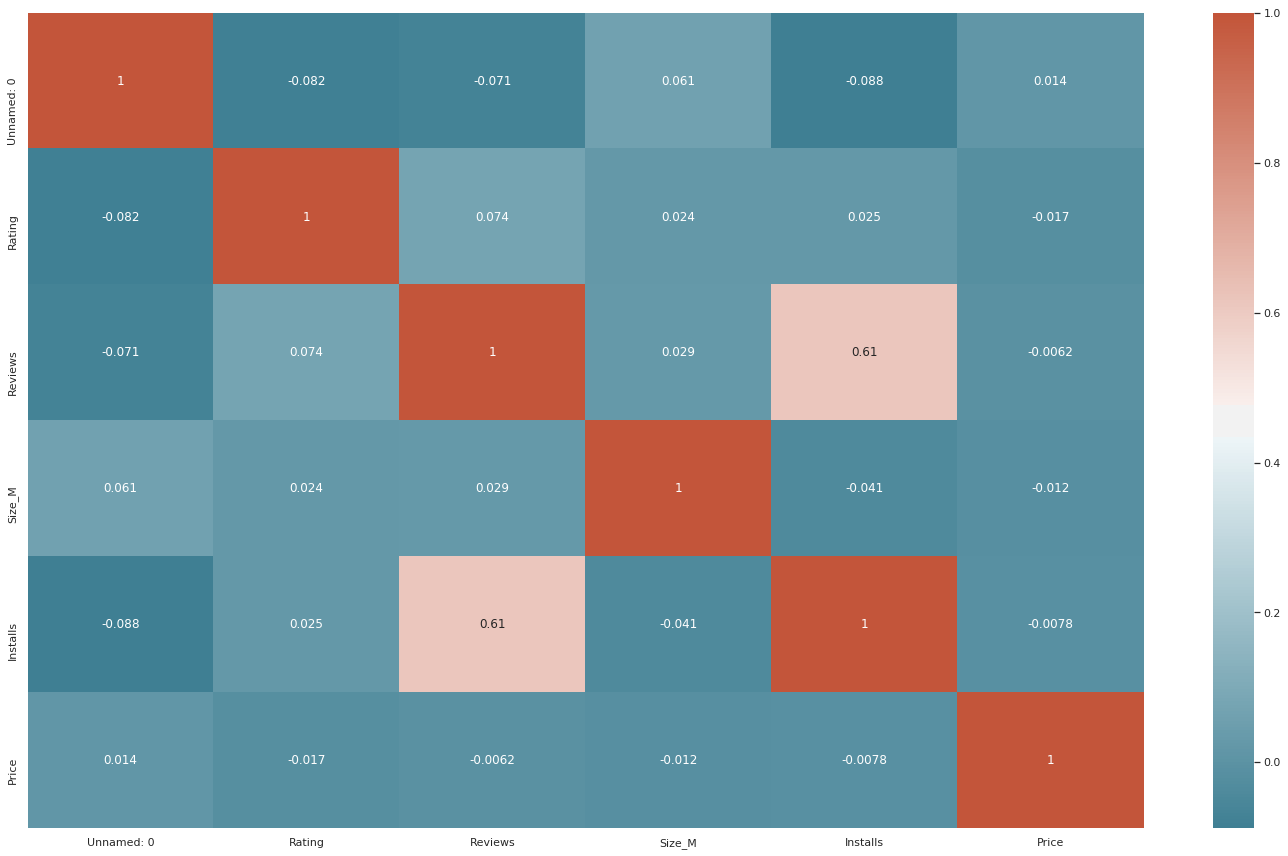

In [19]:
#df['Installs'].corr(df['Reviews'])#df['Insta 
#print(np.corrcoef(l, rating))

corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))


Basic sentiment analysis - User reviews

In [20]:
reviews_df = pd.read_csv('../Data Preprocessing/googleplaystore_user_reviews.csv')

In [21]:
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

grouped_sentiment_category_count = merged_df.groupby(['Category', 'Sentiment']).agg({'App': 'count'}).reset_index()
grouped_sentiment_category_sum = merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()

new_df = pd.merge(grouped_sentiment_category_count, grouped_sentiment_category_sum, on=["Category"])
#print(new_df)
new_df['Sentiment_Normalized'] = new_df.App/new_df.Sentiment_y
new_df = new_df.groupby('Category').filter(lambda x: len(x) ==3)
# new_df = new_df[new_df.Category.isin(['HEALTH_AND_FITNESS', 'GAME', 'FAMILY', 'EDUCATION', 'COMMUNICATION', 
#                                      'ENTERTAINMENT', 'TOOLS', 'SOCIAL', 'TRAVEL_AND_LOCAL'])]
new_df

trace1 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[::3][6:-5],
    name='Negative',
    marker=dict(color = 'rgb(255, 132, 51)')
)

trace2 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[1::3][6:-5],
    name='Neutral',
    marker=dict(color = 'rgb(255, 251, 127)')
)

trace3 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[2::3][6:-5],
    name='Positive',
    marker=dict(color = 'rgb(255, 178, 127)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Sentiment analysis',
    barmode='stack',
    xaxis = {'tickangle': -45},
    yaxis = {'title': 'Fraction of reviews'}
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot({'data': data, 'layout': layout})

Health & Fitness apps perform the best, having more than 77% positive reviews.
On the contrary, many Game and News apps perform bad leading to 50% positive and 50% negative.

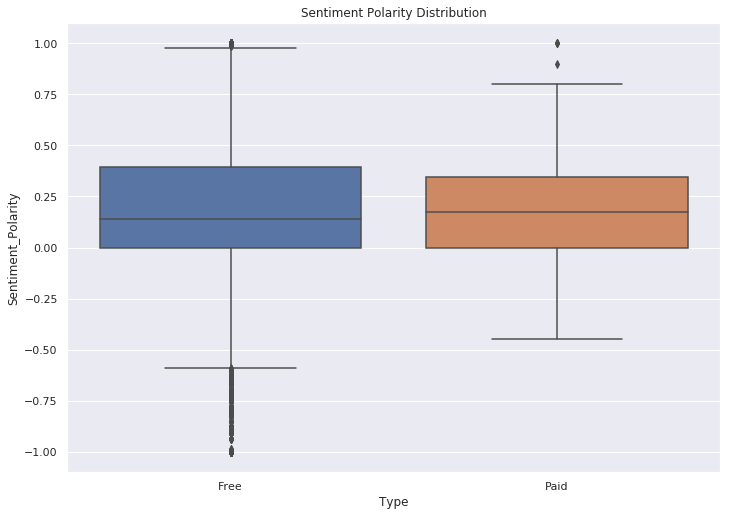

In [22]:
#merged_df.loc[merged_df.Type=='Free']['Sentiment_Polarity']
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

Free apps receive a lot of harsh comments which are indicated as outliers on the negative Y-axis.

Users are more lenient and tolerant while reviewing paid apps - moderate choice of words. They are never extremely negative while reviewing a paid app.